# Risk Measurement Project

Group members : 
- Guillaume IDAME KORALAGE
- Pierre-Arthur HEINRICH
- Mathilde BRUNO
- Ghassan JOUNAIDI
- Paul DE PELLEGARS

### Librairies

In [1]:
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import percentileofscore

import matplotlib.pyplot as plt
import seaborn as sns

from arch import arch_model
from arch.__future__ import reindexing

### Functions

In [2]:
def resample_market_data(df, frequency) : 
    
    index = dict_tenor[frequency] + 1
    resample_df = df.iloc[-index:, :]
    
    return resample_df.dropna(how = "all", axis = 1).dropna(how = "all", axis = 0)

In [28]:
def get_volatility(df) : 
    frequency_return = df.pct_change().dropna()
    volatility = np.sqrt(252) * frequency_return.std()
    return volatility.dropna()

def get_skew(df) : 
    frequency_return = df.pct_change().dropna()
    skew = df.skew()
    return skew.dropna()

def get_robust_skew(df) : 
    frequency_return = df.pct_change().dropna()
    frequency_return_mean = frequency_return.mean()
    frequency_return_median = frequency_return.median()
    frequency_return_std = frequency_return.std()
    robust_skew = (frequency_return_mean - frequency_return_median) / frequency_return_std
    return robust_skew

def get_excess_kurtosis(df) : 
    frequency_return = df.pct_change().dropna()
    excess_kurtosis = df.kurt() - 3
    return excess_kurtosis.dropna()

def get_sharpe_ratio(df) : 
    frequency_return = df.pct_change().dropna()
    sharpe_ratio = np.sqrt(252) * frequency_return.mean() / frequency_return.std()
    return sharpe_ratio

def get_max_drawdown(df):

    frequency_return = df.pct_change().dropna()
    cum_returns = (1 + frequency_return).cumprod()  # Calculate cumulative returns
    window = pd.DataFrame(index=df.index)  # DataFrame to store rolling maximum
    max_drawdown = pd.DataFrame(index=df.columns, columns=["Max Drawdown"])

    for column in cum_returns.columns:
        rolling_max = cum_returns[column].expanding(min_periods=1).max()  # Rolling maximum
        drawdown = cum_returns[column] / rolling_max - 1  # Drawdown calculation
        max_drawdown.loc[column, "Max Drawdown"] = drawdown.min()  # Maximum drawdown

    return max_drawdown

def get_norm_max_drawdown(df):
    volatility = get_volatility(df).to_frame(name = "Volatility")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = max_drawdown/volatility.values
    norm_max_drawdown.columns = ["Norm. Max Drawdown"]
    return norm_max_drawdown

def get_var(df, alpha = 0.05):
    frequency_return = df.pct_change().dropna()
    dict_var = {}
    for column in frequency_return.columns : 
        dict_var[column] = -np.percentile(frequency_return[column], alpha * 100)
    var = pd.DataFrame.from_dict(dict_var, orient = "index", columns = ["VAR " + str((1-alpha) * 100) + "%"])
    return var

def get_expected_shortfall(df, alpha=0.05):
    frequency_return = df.pct_change().dropna()
    dict_es = {}
    
    for column in frequency_return.columns:
        column_returns = frequency_return[column]
        var = -np.percentile(column_returns, alpha * 100)
        es = -np.mean(column_returns[column_returns <= var])
        dict_es[column] = es
    
    es_df = pd.DataFrame.from_dict(dict_es, orient="index", columns=["ES " + str((1-alpha) * 100) + "%"])
    return es_df

def get_risk_metrics(df) :
    volatility = get_volatility(df).to_frame(name = "Volatility")
    skew = get_skew(df).to_frame(name = "Skewness")
    excess_kurtosis = get_excess_kurtosis(df).to_frame(name = "Excess Kurtosis")
    sharpe_ratio = get_sharpe_ratio(df).to_frame(name = "Sharpe Ratio")
    max_drawdown = get_max_drawdown(df)
    norm_max_drawdown = get_norm_max_drawdown(df)
    var = get_var(df, alpha=0.01)
    expected_shortfall = get_expected_shortfall(df, alpha=0.01)


    risk_metrics = pd.concat([volatility,
                              skew, 
                              excess_kurtosis,
                              sharpe_ratio,
                              max_drawdown,
                              norm_max_drawdown,
                              var,
                              expected_shortfall], axis = 1)
    
    return risk_metrics

### Step 1 : Load Data

In [4]:
path_data = "C:/Users/idame/OneDrive/Documents/Guillaume/Education/EDHEC M2 FENG/Risk Measurement/Risk Measurement Hallerbach - data for group assignment.xlsx"

### Step 2 : Pre Processing

In [5]:
#Data
group_daily_data = pd.read_excel(path_data,  skiprows=9, sheet_name = "daily_data")
group_daily_data.set_index("date", inplace = True)

#outliers over 5 std and forward fill
df_return = group_daily_data.pct_change().dropna()
expanding_z_score = df_return.sub(df_return.expanding().mean()).div(df_return.expanding().std()).dropna()
clean_df_return = df_return[abs(expanding_z_score)<5].ffill().dropna()

#Rebase
rebase_group_daily_data = (1 + clean_df_return).cumprod()

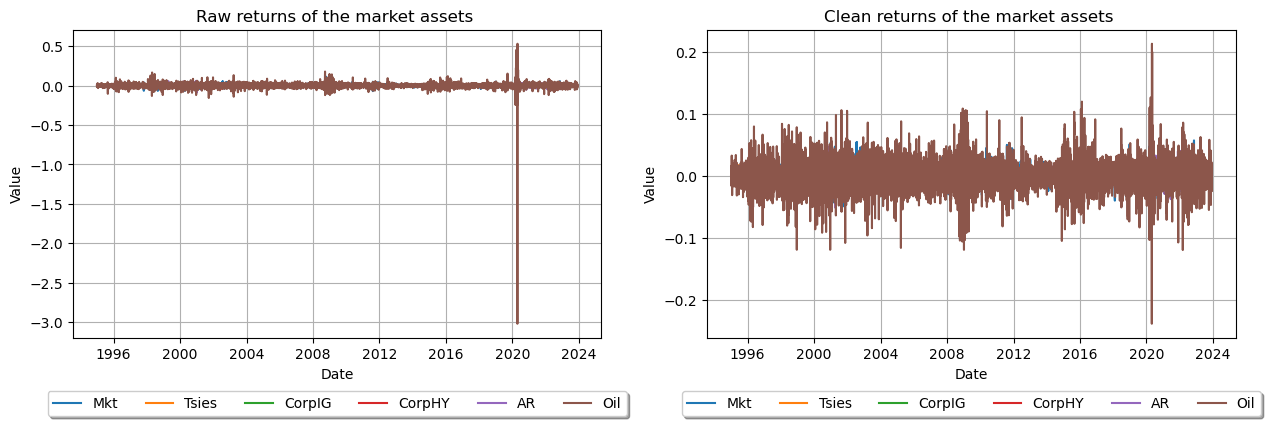

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))

axs[0].plot(df_return, label = df_return.columns)
axs[0].set_title("Raw returns of the market assets ")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Date")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[0].grid()

axs[1].plot(clean_df_return, label = clean_df_return.columns)
axs[1].set_title("Clean returns of the market assets ")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Date")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=6)
axs[1].grid()

### Step 3 : Explore Data

array([[<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>],
       [<Axes: xlabel='date'>, <Axes: xlabel='date'>]], dtype=object)

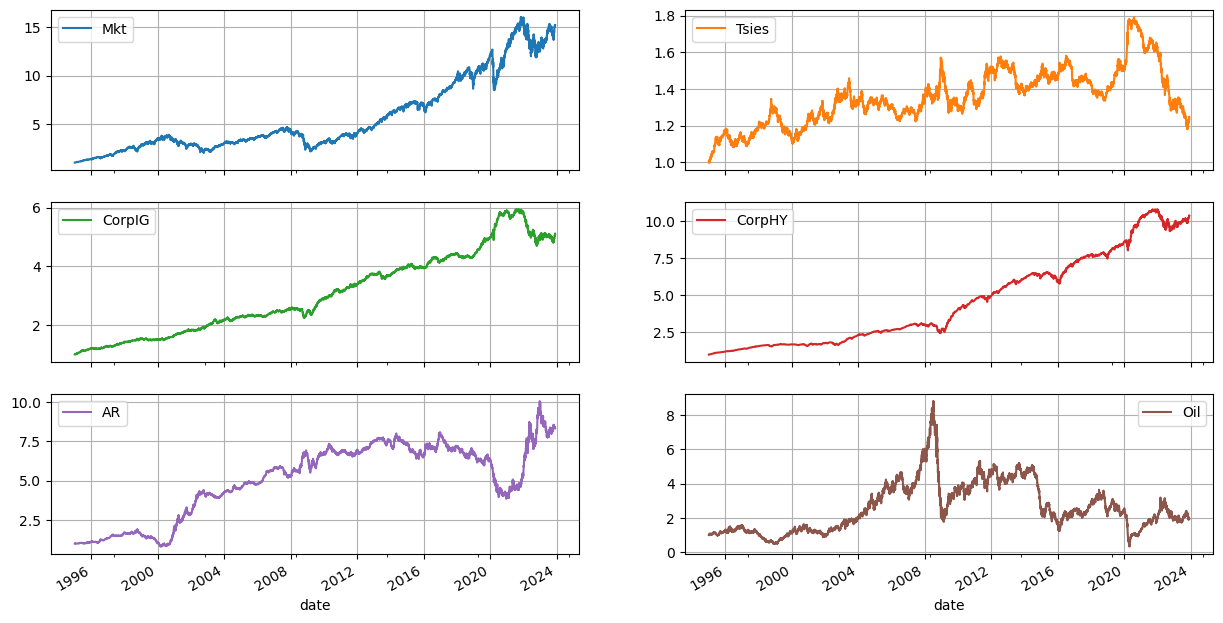

In [7]:
rebase_group_daily_data.plot(subplots = True, grid = True, layout = (3,2), figsize = (15,8))

In [8]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_metrics = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(rebase_group_daily_data, tenor_value)
    dict_tenor_metrics[tenor_value] = get_risk_metrics(resample_adjclose_market_data)

tenor_metrics = pd.concat(dict_tenor_metrics.values(), keys = dict_tenor_metrics.keys(), axis = 1)
tenor_metrics

1W                                                      \
       Volatility  Skewness Excess Kurtosis Sharpe Ratio Max Drawdown   
Mkt      0.033033  1.675271        0.045177     6.179329     -0.00209   
Tsies    0.102410  0.363392       -2.569039     1.998880    -0.008032   
CorpIG   0.080254 -0.033874       -4.207339     6.482825    -0.002956   
CorpHY   0.042096  0.486112       -5.060554    12.403484    -0.000599   
AR       0.012498  0.375649       -4.310786    -8.468495    -0.002588   
Oil      0.363422  0.201815       -4.120815    -1.925260    -0.024497   

                                                      1M            ...  \
       Norm. Max Drawdown VAR 99.0%  ES 99.0% Volatility  Skewness  ...   
Mkt             -0.063271  0.001994 -0.000085   0.117489 -0.740287  ...   
Tsies           -0.078426  0.007870 -0.000812   0.103851 -0.642986  ...   
CorpIG          -0.036836  0.003337  0.001171   0.080080 -0.233897  ...   
CorpHY          -0.014241  0.000576  0.000310   0.059711 -0.747619  ...   
AR              -0.207065  0.001243  0.000420   0.097849  0.729984  ...   
Oil             -0.067407  0.025605  0.002777   0.383486  0.445158  ...   

              2Y                   5Y                                         \
       VAR 99.0%  ES 99.0% Volatility  Skewness Excess Kurtosis Sharpe Ratio   
Mkt     0.035286  0.000091   0.201436 -0.224805       -4.039867     0.530262   
Tsies   0.012977  0.000778   0.082194 -0.023690       -4.137053    -0.180492   
CorpIG  0.010549  0.000372   0.060295  0.022694       -4.149483     0.610136   
CorpHY  0.010051  0.000166   0.053324 -0.519139       -3.999152     1.170445   
AR      0.030295 -0.000640   0.201813  0.186323       -4.183994     0.279378   
Oil     0.067477  0.000253   0.466984 -0.514363       -3.237529     0.143438   

                                                            
       Max Drawdown Norm. Max Drawdown VAR 99.0%  ES 99.0%  
Mkt       -0.331198          -1.644181  0.037406 -0.000141  
Tsies     -0.340728          -4.145426  0.012426  0.000336  
CorpIG      -0.2107          -3.494507  0.010126 -0.000052  
CorpHY    -0.137836          -2.584874  0.009256 -0.000053  
AR         -0.44347          -2.197432  0.029929  0.000288  
Oil       -0.893743          -1.913861  0.080793  0.000705  

[6 rows x 56 columns]

In [9]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}
list_tenor = list(dict_tenor.keys())

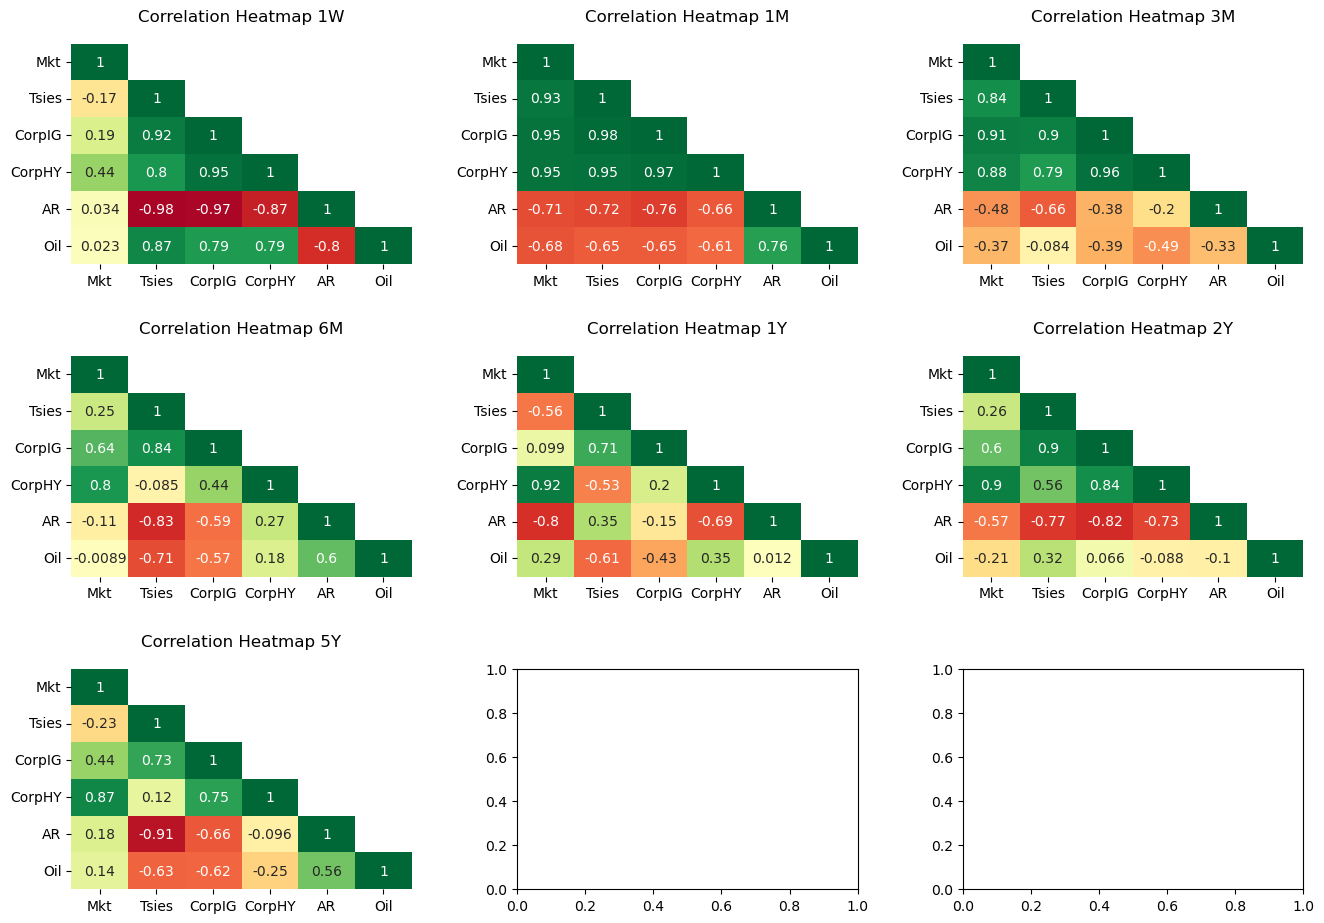

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(14, 10))
fig.tight_layout(pad=4.5)

#1W
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1W"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1W"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,0])
heatmap.set_title('Correlation Heatmap 1W', fontdict={'fontsize':12}, pad=16);

#1M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,1])
heatmap.set_title('Correlation Heatmap 1M', fontdict={'fontsize':12}, pad=16);

#3M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["3M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["3M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[0,2])
heatmap.set_title('Correlation Heatmap 3M', fontdict={'fontsize':12}, pad=16);

#6M
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["6M"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["6M"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,0])
heatmap.set_title('Correlation Heatmap 6M', fontdict={'fontsize':12}, pad=16);

#1Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["1Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["1Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,1])
heatmap.set_title('Correlation Heatmap 1Y', fontdict={'fontsize':12}, pad=16);

#2Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["2Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["2Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[1,2])
heatmap.set_title('Correlation Heatmap 2Y', fontdict={'fontsize':12}, pad=16);

#5Y
mask = np.triu(np.ones_like(rebase_group_daily_data.iloc[-dict_tenor["5Y"]:].corr(), dtype=np.bool_), k=1)
heatmap = sns.heatmap(rebase_group_daily_data.iloc[-dict_tenor["5Y"]:].corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='RdYlGn', cbar=False, ax = axs[2,0])
heatmap.set_title('Correlation Heatmap 5Y', fontdict={'fontsize':12}, pad=16);

### Step 4 : Construction Portfolios : Default, Active, Augmented

In [11]:
#Weights
default_weights = [0.5, 0.2, 0.05, 0.05, 0.15, 0.05]
active_weights = [-0.1, 0.15, -0.05, -0.05, 0.10, -0.05]
augmented_weights = [0.40, 0.35, 0, 0, 0.25, 0]

#Breakdown
breakdown_default_portfolio = default_weights * rebase_group_daily_data
breakdown_active_portfolio = active_weights * rebase_group_daily_data
breakdown_augmented_weights_portfolio = augmented_weights * rebase_group_daily_data

#Porfolios
default_portfolio = breakdown_default_portfolio.sum(axis = 1).to_frame(name = "default")
active_portfolio = breakdown_active_portfolio.sum(axis = 1).to_frame(name = "active")
augmented_weights_portfolio = breakdown_augmented_weights_portfolio.sum(axis = 1).to_frame(name = "augmented")

#Aggregated Portfolios
aggregated_portfolios = pd.concat([default_portfolio, active_portfolio, augmented_weights_portfolio], axis = 1)
return_aggregated_portfolios = aggregated_portfolios.pct_change().dropna()

aggregated_portfolios.head()

,default,active,augmented
date,,,
1995-01-04,1.004075,0.000301,1.004376
1995-01-05,1.003616,-0.000874,1.002742
1995-01-06,1.004348,-0.000884,1.003464
1995-01-09,1.003149,-0.000678,1.002472
1995-01-10,1.004361,-0.001193,1.003168


In [12]:
aggregated_portfolios

,default,active,augmented
date,,,
1995-01-04,1.004075,0.000301,1.004376
1995-01-05,1.003616,-0.000874,1.002742
1995-01-06,1.004348,-0.000884,1.003464
1995-01-09,1.003149,-0.000678,1.002472
1995-01-10,1.004361,-0.001193,1.003168
...,...,...,...
2023-11-24,9.954453,-1.363509,8.590944
2023-11-27,9.940984,-1.362603,8.578381
2023-11-28,9.951737,-1.367725,8.584012


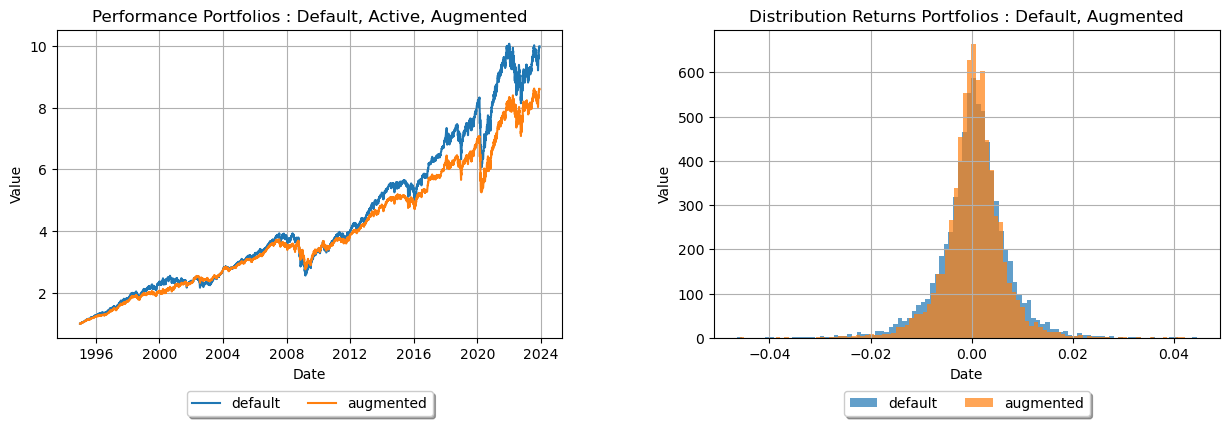

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (15, 4))
axs[0].plot(aggregated_portfolios[["default", "augmented"]], label = aggregated_portfolios[["default", "augmented"]].columns)
axs[0].set_title("Performance Portfolios : Default, Active, Augmented")
axs[0].set_ylabel("Value")
axs[0].set_xlabel("Date")
axs[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
axs[0].grid()

aggregated_portfolios[["default"]].pct_change().dropna().hist(bins = 100, alpha = 0.7, ax = axs[1], grid = False, label = "default")
aggregated_portfolios[["augmented"]].pct_change().dropna().hist(bins = 100, alpha = 0.7, ax = axs[1], grid = False, label = "augmented")
axs[1].set_title("Distribution Returns Portfolios : Default, Augmented")
axs[1].set_ylabel("Value")
axs[1].set_xlabel("Date")
axs[1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=True, ncol=5)
axs[1].grid()

### Questions

#### Q1 - what is the ex-ante risk profile of the augmented portfolio on Thursday 30-Nov-2023 close and how does this compare against the default mix ?

For tackling this question you have to decide on what risk measures and what parameter settings you deem relevant to capture the ex-ante risks of these portfolios. Motivate your choices and interpret the estimated risk statistics.

#### Volatility (Standard Deviation):
Augmented Portfolio:
Calculate the standard deviation of daily or weekly returns for the augmented portfolio. A higher standard deviation indicates higher volatility.

Default Mix:
Perform the same calculation for the standard deviation of daily or weekly returns for the default mix.

Comparison:
Compare the standard deviations of the augmented portfolio and the default mix. The portfolio with a higher standard deviation is considered to have higher volatility and, hence, higher risk.

#### Skewness:
Augmented Portfolio:
Compute the skewness of the augmented portfolio returns. Positive skewness indicates a longer right tail, while negative skewness indicates a longer left tail.

Default Mix:
Calculate the skewness of the returns for the default mix.

Comparison:
Compare the skewness values. Positive skewness might suggest a potential for higher positive returns but with a caution about extreme positive returns. Negative skewness may indicate a higher risk of extreme negative returns.

#### Excess Kurtosis:
Augmented Portfolio:
Calculate the excess kurtosis of the augmented portfolio returns. Positive excess kurtosis suggests fat tails, while negative excess kurtosis suggests thinner tails.

Default Mix:
Compute the excess kurtosis for the returns of the default mix.

Comparison:
Compare the excess kurtosis values. Positive excess kurtosis may indicate a portfolio with a higher likelihood of extreme returns, contributing to tail risk.

#### Sharpe Ratio:
Augmented Portfolio:
Compute the Sharpe Ratio, which measures the risk-adjusted return for the augmented portfolio.

Default Mix:
Calculate the Sharpe Ratio for the default mix.

Comparison:
Compare the Sharpe Ratios. A higher Sharpe Ratio suggests better risk-adjusted performance.

#### Value at Risk (VaR):
Augmented Portfolio:
Calculate VaR at a specified confidence level (e.g., 95% or 99%) for the augmented portfolio.

Default Mix:
Perform the same calculation for VaR for the default mix.

Comparison:
Compare the VaR values. A higher VaR implies a higher potential loss, indicating higher risk.

#### Conditional Value at Risk (CVaR or Expected Shortfall):
Augmented Portfolio:
Calculate CVaR at the same confidence level as VaR for the augmented portfolio.

Default Mix:
Compute CVaR for the default mix.

Comparison:
Compare the CVaR values. Higher CVaR indicates higher risk in the tail distribution of potential losses.

In [14]:
dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_metrics = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(aggregated_portfolios, tenor_value)
    dict_tenor_metrics[tenor_value] = get_risk_metrics(resample_adjclose_market_data)

tenor_metrics = pd.concat(dict_tenor_metrics.values(), keys = dict_tenor_metrics.keys(), axis = 1)
tenor_metrics

1W                                                      \
          Volatility  Skewness Excess Kurtosis Sharpe Ratio Max Drawdown   
default     0.021397  1.445251       -0.326164     8.410752    -0.001353   
active      0.039365 -0.769463       -4.547601    12.770149    -0.000664   
augmented   0.021894  1.553418        0.067084     5.874967    -0.001462   

                                                         1M            ...  \
          Norm. Max Drawdown VAR 99.0%  ES 99.0% Volatility  Skewness  ...   
default            -0.063234  0.001278 -0.000299   0.096928 -0.768136  ...   
active             -0.016868  0.000649  0.000470   0.155233  0.627708  ...   
augmented          -0.066795  0.001392 -0.000034   0.091136 -0.808876  ...   

                 2Y                   5Y                            \
          VAR 99.0%  ES 99.0% Volatility  Skewness Excess Kurtosis   
default    0.025289  0.000017   0.147380 -0.333660       -4.133011   
active     0.050717  0.000848   0.288818 -0.391211       -3.790648   
augmented  0.020199  0.000104   0.133859 -0.273797       -4.214057   

                                                                            
          Sharpe Ratio Max Drawdown Norm. Max Drawdown VAR 99.0%  ES 99.0%  
default       0.560732     -0.27224          -1.847202  0.027025 -0.000124  
active        0.514160    -0.521791          -1.806642  0.049869 -0.000044  
augmented     0.565247    -0.257367           -1.92268  0.024582 -0.000114  

[3 rows x 56 columns]

### View on Each Portfolio

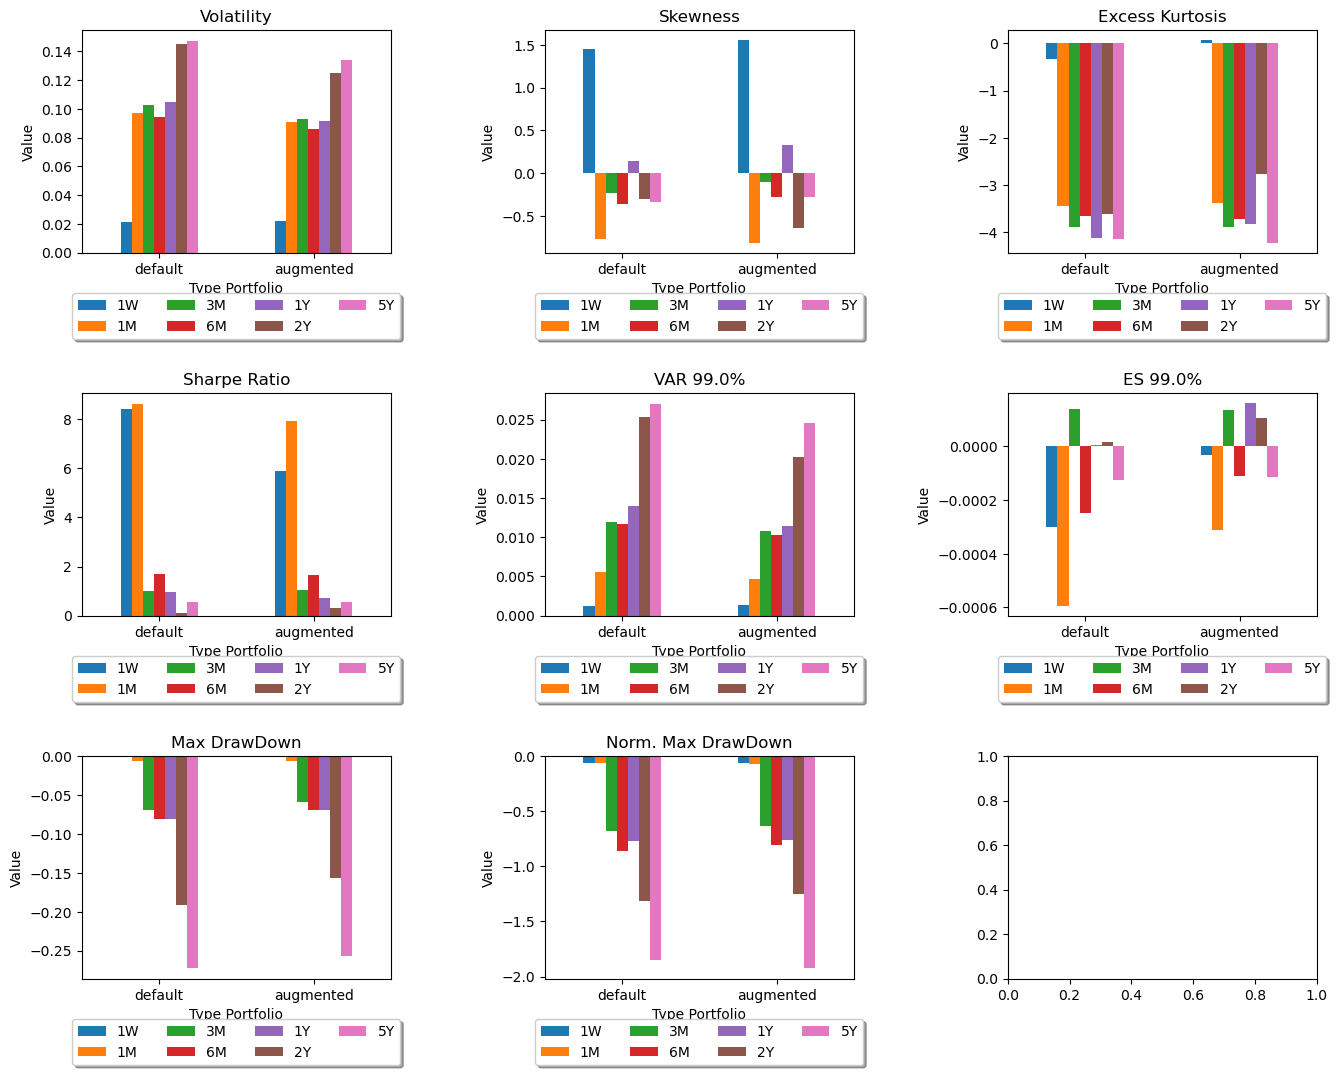

In [15]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.tight_layout(pad=8.0)

tenor_metrics.loc[["default", "augmented"]].xs("Volatility", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,0])
axs[0,0].set_title("Volatility")
axs[0,0].set_xlabel("Type Portfolio")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Skewness", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,1])
axs[0,1].set_title("Skewness")
axs[0,1].set_xlabel("Type Portfolio")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Excess Kurtosis", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[0,2])
axs[0,2].set_title("Excess Kurtosis")
axs[0,2].set_xlabel("Type Portfolio")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Sharpe Ratio", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,0])
axs[1,0].set_title("Sharpe Ratio")
axs[1,0].set_xlabel("Type Portfolio")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("VAR 99.0%", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,1])
axs[1,1].set_title("VAR 99.0%")
axs[1,1].set_xlabel("Type Portfolio")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("ES 99.0%", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[1,2])
axs[1,2].set_title("ES 99.0%")
axs[1,2].set_xlabel("Type Portfolio")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

tenor_metrics.loc[["default", "augmented"]].xs("Max Drawdown", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[2,0])
axs[2,0].set_title("Max DrawDown")
axs[2,0].set_xlabel("Type Portfolio")
axs[2,0].set_ylabel("Value")
axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)


tenor_metrics.loc[["default", "augmented"]].xs("Norm. Max Drawdown", axis = 1, level = 1).plot(kind = "bar", rot = 0, ax = axs[2,1])
axs[2,1].set_title("Norm. Max DrawDown")
axs[2,1].set_xlabel("Type Portfolio")
axs[2,1].set_ylabel("Value")
axs[2,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),fancybox=True, shadow=True, ncol=4)

### View on Each Tenor

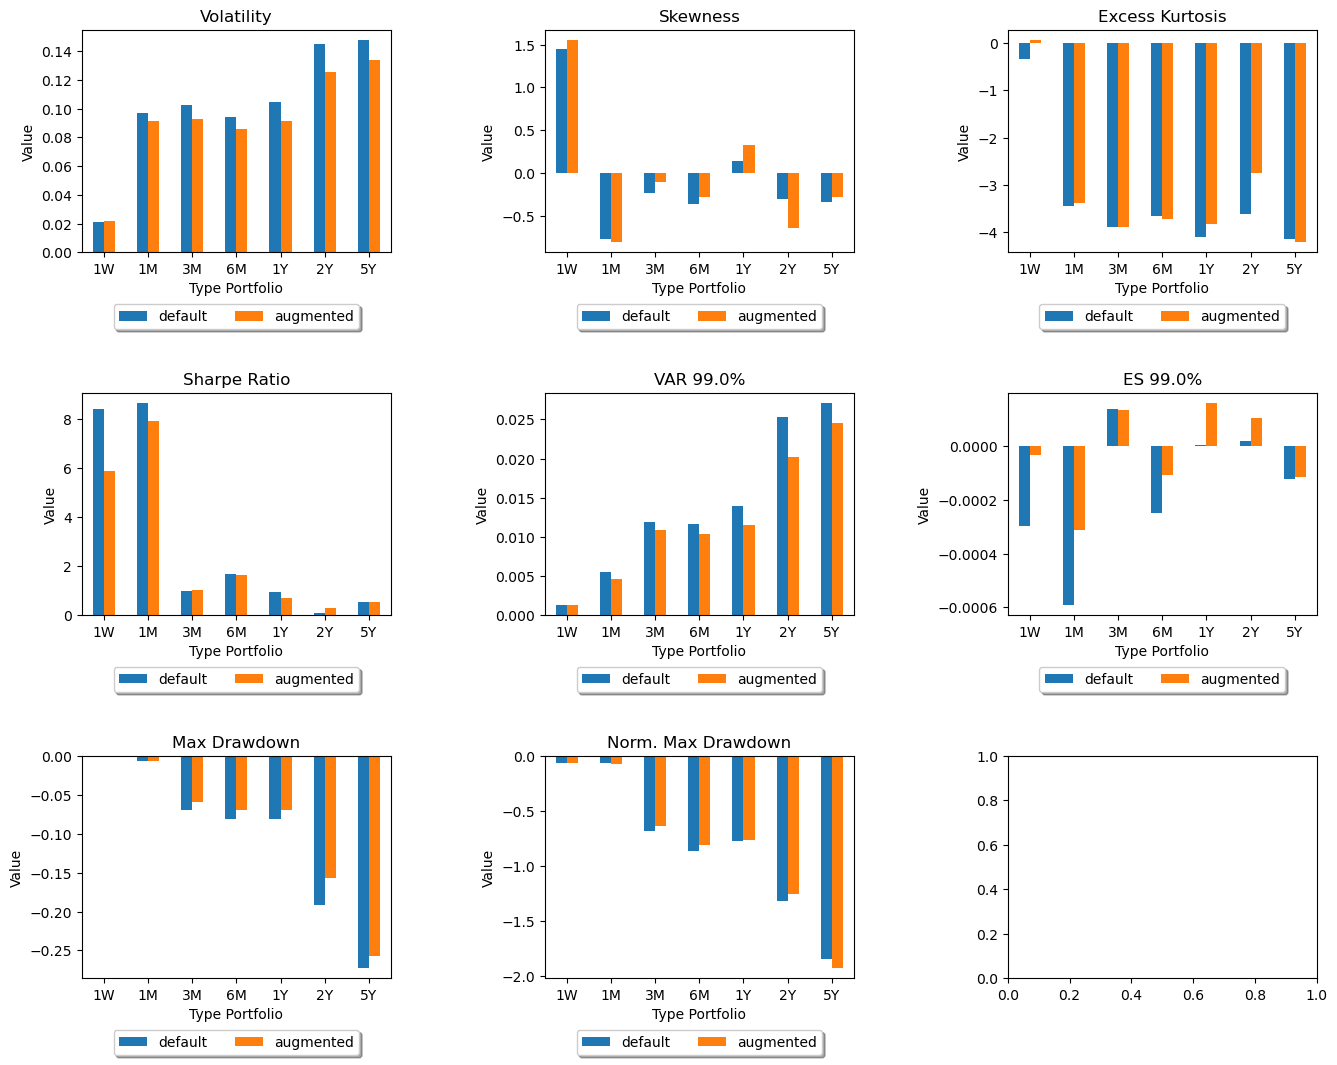

In [16]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.tight_layout(pad=8.0)

tenor_metrics.loc[["default", "augmented"]].xs("Volatility", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,0])
axs[0,0].set_title("Volatility")
axs[0,0].set_xlabel("Type Portfolio")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("Skewness", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,1])
axs[0,1].set_title("Skewness")
axs[0,1].set_xlabel("Type Portfolio")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("Excess Kurtosis", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[0,2])
axs[0,2].set_title("Excess Kurtosis")
axs[0,2].set_xlabel("Type Portfolio")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("Sharpe Ratio", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,0])
axs[1,0].set_title("Sharpe Ratio")
axs[1,0].set_xlabel("Type Portfolio")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("VAR 99.0%", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,1])
axs[1,1].set_title("VAR 99.0%")
axs[1,1].set_xlabel("Type Portfolio")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("ES 99.0%", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[1,2])
axs[1,2].set_title("ES 99.0%")
axs[1,2].set_xlabel("Type Portfolio")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("Max Drawdown", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[2,0])
axs[2,0].set_title("Max Drawdown")
axs[2,0].set_xlabel("Type Portfolio")
axs[2,0].set_ylabel("Value")
axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

tenor_metrics.loc[["default", "augmented"]].xs("Norm. Max Drawdown", axis = 1, level = 1).T.plot(kind = "bar", rot = 0, ax = axs[2,1])
axs[2,1].set_title("Norm. Max Drawdown")
axs[2,1].set_xlabel("Type Portfolio")
axs[2,1].set_ylabel("Value")
axs[2,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=3)

### Marginal Risk Contribution

In [17]:
def get_mcr(returns, list_weights) : 
    cov_matrix = returns.cov() * 252
    portfolio_weights = np.array(list_weights)
    portfolio_variance = np.dot(portfolio_weights.T, np.dot(portfolio_weights, portfolio_weights))
    portfolio_vol = np.sqrt(portfolio_variance)  
    asset_contribution = np.dot(cov_matrix, portfolio_weights) * portfolio_weights
    mcr = asset_contribution / portfolio_vol
    mcr_data = pd.DataFrame(mcr, index = returns.columns, columns  = ["MCR"])
    return mcr_data

def get_multi_mcr(returns, list_weights, list_type_portfolio) : 
    
    dict_mcr = {}
    for weights, type_portfolio in zip(list_weights, list_type_portfolio) :
        mcr_portfolio = get_mcr(returns, weights)
        mcr_portfolio.columns = [type_portfolio]
        dict_mcr[type_portfolio] = mcr_portfolio

    mcr_data = pd.concat(dict_mcr.values(), axis = 1)
    
    return mcr_data

In [18]:
default_weights = [0.5, 0.2, 0.05, 0.05, 0.15, 0.05]
active_weights = [-0.1, 0.15, -0.05, -0.05, 0.10, -0.05]
augmented_weights = [0.40, 0.35, 0, 0, 0.25, 0]

list_weights = [default_weights, augmented_weights]
list_type_portfolio = ["default", "augmented"]

dict_tenor = {"1D" : 1, "1W" : 5, "1M" : 22, "3M" : 66, "6M" : 132,
             "1Y" : 252, "2Y" : 252 * 2, "5Y" : 252 * 5}

list_tenor = list(dict_tenor.keys())

dict_tenor_mcr = {}

for tenor_value in list_tenor[1:] : 
    resample_adjclose_market_data = resample_market_data(clean_df_return, tenor_value)
    dict_tenor_mcr[tenor_value] = get_multi_mcr(resample_adjclose_market_data, list_weights, list_type_portfolio)

tenor_mcr = pd.concat(dict_tenor_mcr.values(), keys = dict_tenor_mcr.keys(), axis = 1)
tenor_mcr

C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local\Temp\ipykernel_35764\1725782678.py:7: RuntimeWarning: invalid value encountered in divide
  mcr = asset_contribution / portfolio_vol
C:\Users\idame\AppData\Local

1W                  1M                  3M                  6M  \
         default augmented   default augmented   default augmented   default   
Mkt    -0.000331 -0.000377  0.011097  0.008662  0.012021  0.008773  0.010038   
Tsies   0.001578  0.001754  0.004212  0.005501  0.003424  0.004634  0.002698   
CorpIG  0.000601       NaN  0.001757       NaN  0.001514       NaN  0.001155   
CorpHY  0.000378       NaN  0.001635       NaN  0.001343       NaN  0.001038   
AR     -0.000118 -0.000166  0.001782  0.001855  0.000020  0.000565  0.000283   
Oil     0.003569       NaN  0.004332       NaN  0.001400       NaN  0.002292   

                        1Y                  2Y                  5Y            
       augmented   default augmented   default augmented   default augmented  
Mkt     0.006861  0.012901  0.007119  0.024000  0.012942  0.024817  0.014363  
Tsies   0.003722  0.001664  0.002892  0.002046  0.003312 -0.000036  0.000855  
CorpIG       NaN  0.000901       NaN  0.001044       NaN  0.000440       NaN  
CorpHY       NaN  0.001129       NaN  0.001552       NaN  0.001218       NaN  
AR      0.001364 -0.000791  0.001419 -0.002853  0.001817  0.000773  0.004464  
Oil          NaN  0.004254       NaN  0.005860       NaN  0.008377       NaN

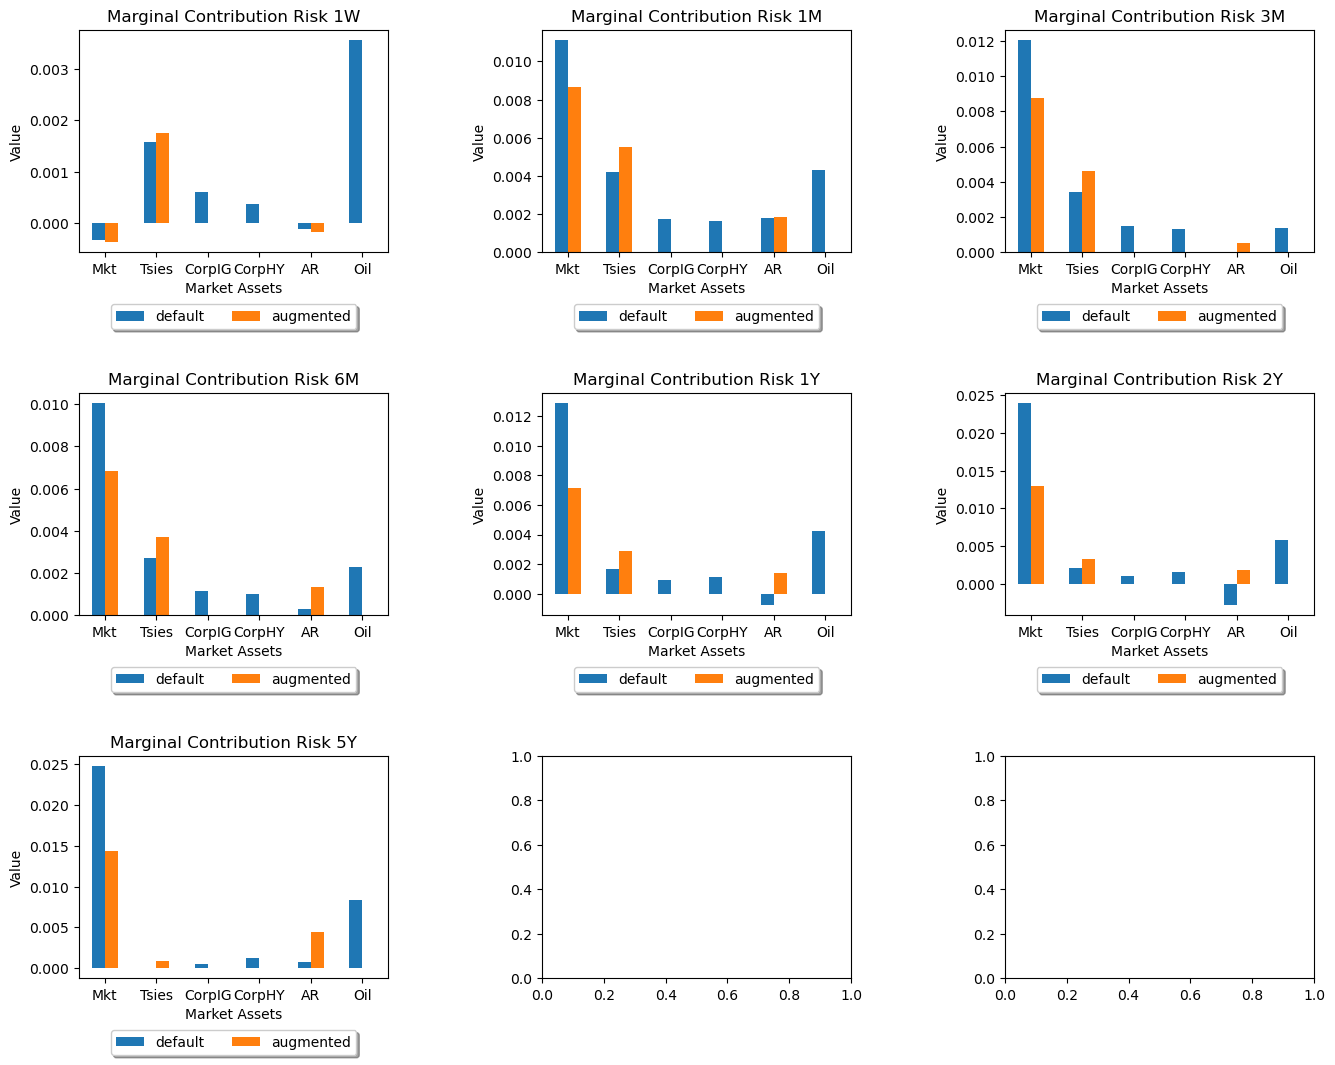

In [19]:
fig, axs = plt.subplots(3, 3, figsize = (15, 12))
fig.tight_layout(pad=8.0)

tenor_mcr.xs("1W", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,0], rot = 0)
axs[0,0].set_title("Marginal Contribution Risk 1W")
axs[0,0].set_xlabel("Market Assets")
axs[0,0].set_ylabel("Value")
axs[0,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("1M", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,1], rot = 0)
axs[0,1].set_title("Marginal Contribution Risk 1M")
axs[0,1].set_xlabel("Market Assets")
axs[0,1].set_ylabel("Value")
axs[0,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("3M", axis = 1, level = 0).plot(kind = "bar", ax = axs[0,2], rot = 0)
axs[0,2].set_title("Marginal Contribution Risk 3M")
axs[0,2].set_xlabel("Market Assets")
axs[0,2].set_ylabel("Value")
axs[0,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("6M", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,0], rot = 0)
axs[1,0].set_title("Marginal Contribution Risk 6M")
axs[1,0].set_xlabel("Market Assets")
axs[1,0].set_ylabel("Value")
axs[1,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("1Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,1], rot = 0)
axs[1,1].set_title("Marginal Contribution Risk 1Y")
axs[1,1].set_xlabel("Market Assets")
axs[1,1].set_ylabel("Value")
axs[1,1].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("2Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[1,2], rot = 0)
axs[1,2].set_title("Marginal Contribution Risk 2Y")
axs[1,2].set_xlabel("Market Assets")
axs[1,2].set_ylabel("Value")
axs[1,2].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

tenor_mcr.xs("5Y", axis = 1, level = 0).plot(kind = "bar", ax = axs[2,0], rot = 0)
axs[2,0].set_title("Marginal Contribution Risk 5Y")
axs[2,0].set_xlabel("Market Assets")
axs[2,0].set_ylabel("Value")
axs[2,0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.20),fancybox=True, shadow=True, ncol=4)

### Volatility Modeling

In [23]:
def get_equally_weighted_volatility(df, windows) :
    return df.rolling(windows).std()

def fit_garch(p, q, df):
    """
    Fit GARCH(p, q) model to financial returns.

    Parameters:
    - p (int): Order of the autoregressive component.
    - q (int): Order of the moving average component.
    - returns (pd.Series): Time series of financial returns.

    Returns:
    - model_fit: Fitted GARCH(p, q) model.
    """
    # Define GARCH(p, q) model
    model = arch_model(df, vol='Garch', p=p, q=q)

    # Fit the model
    model_fit = model.fit()

    return model_fit

def get_garch_volatility(p, q, df) :
    model_fit = fit_garch(p, q, df)

    #Conditionnal Vol
    garch_volatility = model_fit.conditional_volatility
    garch_volatility_data = garch_volatility.to_frame(name = "GARCH (" + str(p)+","+str(q)+")")
    
    return garch_volatility_data

def get_ewma_volatility(df, alpha):
    """
    Calculate Exponential Weighted Moving Average (EWMA) volatility for a given time series of returns.

    Parameters:
    - returns (pd.Series): Time series of returns.
    - alpha (float): Smoothing factor (0 < alpha <= 1).

    Returns:
    - ewma_volatility (pd.Series): Series containing EWMA volatility values.
    """
    squared_returns = df ** 2
    ewma_volatility = np.sqrt(squared_returns.ewm(alpha=alpha, adjust=False).mean())
    ewma_volatility.columns = ["EWMA "+str(1-alpha)]

    return ewma_volatility

def get_conditional_volatilities(df) :
    
    #GARCH(1,1)
    p = 1
    q = 1
    garch_volatility = get_garch_volatility(p, q, df)

    #EWMA 0.94
    alpha_94 = 0.06
    ewma_volatility_94 = get_ewma_volatility(df, alpha_94)
    #EWMA 0.97
    alpha_97 = 0.03
    ewma_volatility_97 = get_ewma_volatility(df, alpha_97)

    return garch_volatility, ewma_volatility_94, ewma_volatility_97

In [24]:
def get_evaluation_criterions(returns, conditional_vol) :

    z_score = returns.values/conditional_vol

    #Average Biais
    average_zscore = z_score.mean()
    std_zscore = z_score.std()
    upper_bound_95 = (1 - np.sqrt(2/len(z_score))) * std_zscore
    lower_bound_95 = (1 + np.sqrt(2/len(z_score))) * std_zscore

    #Biais over time
    rolling_std_zscore = z_score.rolling(52).std().dropna()
    mean_rolling_absolute_deviation = abs(rolling_std_zscore - 1).sum() * 1/len(rolling_std_zscore)

    #Distribution
    excess_kurtosis_zscore = get_excess_kurtosis(z_score)
    skew_zscore = get_skew(z_score)
    robust_skew_zscore = get_robust_skew(z_score)

    #Relative
    squared_z_score = z_score ** 2
    quasi_likelihood = np.log(squared_z_score) - squared_z_score
    sum_quasi_likelihood = quasi_likelihood.sum()

    metrics = pd.concat([average_zscore, 
                         std_zscore, 
                         upper_bound_95, 
                         lower_bound_95,
                         mean_rolling_absolute_deviation,
                         excess_kurtosis_zscore,
                         skew_zscore,
                         robust_skew_zscore,
                         sum_quasi_likelihood], 
                         keys = ["Mean Z_Score",
                                 "Std Z_score",
                                 "upper 95%", 
                                 "lower 95%",
                                 "MRAD",
                                 "Excess Kurtosis",
                                 "Skew",
                                 "Robust Skew",
                                 "Sum Quasi-likelihood"] ,axis = 1)
    
    
    return metrics

def get_portfolio_evaluation_criterions(df) :
    
    garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)

    #Conditional Vol
    list_conditional_vol = [garch_volatility, ewma_volatility_94, ewma_volatility_97]
    list_name_conditional_vol = [garch_volatility.columns[0], ewma_volatility_94.columns[0], ewma_volatility_97.columns[0]] 

    dict_evaluation_criterions = {}
    for conditional_vol, name_conditional_vol in zip(list_conditional_vol, list_name_conditional_vol) :
        dict_evaluation_criterions[name_conditional_vol] = get_evaluation_criterions(df, conditional_vol)

    evaluation_criterions = pd.concat(dict_evaluation_criterions.values())
    
    return evaluation_criterions

In [25]:
#Different Vol
df = return_aggregated_portfolios["default"].to_frame() *100
equally_weighted_volatility = get_equally_weighted_volatility(df, 52) 
garch_volatility, ewma_volatility_94, ewma_volatility_97 = get_conditional_volatilities(df)

#All Vols
all_volatility = pd.concat([equally_weighted_volatility, garch_volatility, ewma_volatility_94, ewma_volatility_97], axis = 1)

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6205581168126962.0
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4085873208.7536173
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6425.9769680012
Iteration:      4,   Func. Count:     30,   Neg. LLF: 10248.883204930104
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6355.536226359951
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6563.611804275159
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6369.5605148332
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6345.225403754191
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6344.158839974359
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6344.158635462127
Iteration:     11,   Func. Count:     71,   Neg. LLF: 6344.158635458377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6344.158635462127
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations: 11


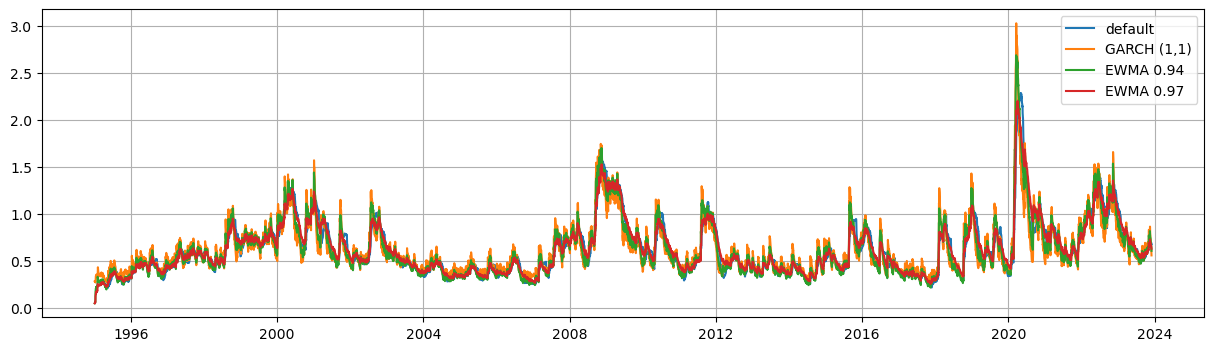

In [26]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(all_volatility, label = all_volatility.columns)
ax.legend()
ax.grid()

In [29]:
default_evaluation_criterions = get_portfolio_evaluation_criterions(return_aggregated_portfolios["default"].to_frame()*100)
augmented_evaluation_criterions = get_portfolio_evaluation_criterions(return_aggregated_portfolios["augmented"].to_frame()*100)
global_evaluation_criterions= pd.concat([default_evaluation_criterions, augmented_evaluation_criterions], keys = ["default", "active"], axis = 0)
global_evaluation_criterions

Iteration:      1,   Func. Count:      6,   Neg. LLF: 6205581168126962.0
Iteration:      2,   Func. Count:     16,   Neg. LLF: 4085873208.7536173
Iteration:      3,   Func. Count:     24,   Neg. LLF: 6425.9769680012
Iteration:      4,   Func. Count:     30,   Neg. LLF: 10248.883204930104
Iteration:      5,   Func. Count:     38,   Neg. LLF: 6355.536226359951
Iteration:      6,   Func. Count:     44,   Neg. LLF: 6563.611804275159
Iteration:      7,   Func. Count:     50,   Neg. LLF: 6369.5605148332
Iteration:      8,   Func. Count:     56,   Neg. LLF: 6345.225403754191
Iteration:      9,   Func. Count:     62,   Neg. LLF: 6344.158839974359
Iteration:     10,   Func. Count:     67,   Neg. LLF: 6344.158635462127
Iteration:     11,   Func. Count:     71,   Neg. LLF: 6344.158635458377
Optimization terminated successfully    (Exit mode 0)
            Current function value: 6344.158635462127
            Iterations: 11
            Function evaluations: 71
            Gradient evaluations: 11


Mean Z_Score  Std Z_score  upper 95%  lower 95%  \
default GARCH (1,1)      0.064249     0.999355   0.982788   1.015921   
        EWMA 0.94        0.074527     0.967679   0.951638   0.983721   
        EWMA 0.97        0.071730     0.986465   0.970112   1.002818   
active  GARCH (1,1)      0.070404     0.999591   0.983021   1.016161   
        EWMA 0.94        0.078468     0.964760   0.948767   0.980753   
        EWMA 0.97        0.075768     0.981488   0.965218   0.997758   

                         MRAD  Excess Kurtosis      Skew  Robust Skew  \
default GARCH (1,1)  0.094175        -1.605345 -0.423001    -0.004892   
        EWMA 0.94    0.085478        -2.960091 -0.238929    -0.005105   
        EWMA 0.97    0.125551        -2.378867 -0.268650    -0.005006   
active  GARCH (1,1)  0.096811        -1.472810 -0.352881    -0.012531   
        EWMA 0.94    0.085865        -2.938126 -0.213840    -0.012480   
        EWMA 0.97    0.125174        -2.392650 -0.251039    -0.012509   

                     Sum Quasi-likelihood  
default GARCH (1,1)         -17715.168702  
        EWMA 0.94           -16759.219541  
        EWMA 0.97           -17376.177975  
active  GARCH (1,1)         -17696.000804  
        EWMA 0.94           -16697.186725  
        EWMA 0.97           -17298.491335

#### Q2 - how do the tail risks of the portfolio change after implementing the active positions ?

### Cumulative Ranked Amplitude Plot (CRAP) 

In [30]:
return_default = aggregated_portfolios["default"].pct_change().dropna()
abs_return_default = abs(return_default)
rank_return_default = abs_return_default.rank()

crap_default = pd.concat([return_default, abs_return_default, rank_return_default], axis = 1, names = ["Return default", "Rank Return default"])
crap_default.columns = ["Return default", "Abs Return default", "Rank Return default"]
crap_default.set_index("Rank Return default", inplace = True)
crap_default.sort_index(inplace = True)
crap_default["Cum Return default"] = crap_default["Return default"].cumsum()

metric_default = crap_default["Cum Return default"].iloc[-1] / max(crap_default["Cum Return default"])

In [31]:
metric_default

0.7412867121473475

In [32]:
return_augmented = aggregated_portfolios["augmented"].pct_change().dropna()
abs_return_augmented = abs(return_augmented)
rank_return_augmented = abs_return_augmented.rank()

crap_augmented = pd.concat([return_augmented, abs_return_augmented, rank_return_augmented], axis = 1, names = ["Return augmented", "Rank Return augmented"])
crap_augmented.columns = ["Return augmented", "Abs Return augmented", "Rank Return augmented"]
crap_augmented.set_index("Rank Return augmented", inplace = True)
crap_augmented.sort_index(inplace = True)
crap_augmented["Cum Return augmented"] = crap_augmented["Return augmented"].cumsum()

metric_augmented = crap_augmented["Cum Return augmented"].iloc[-1] / max(crap_augmented["Cum Return augmented"])

In [33]:
metric_augmented

0.7975615966197784

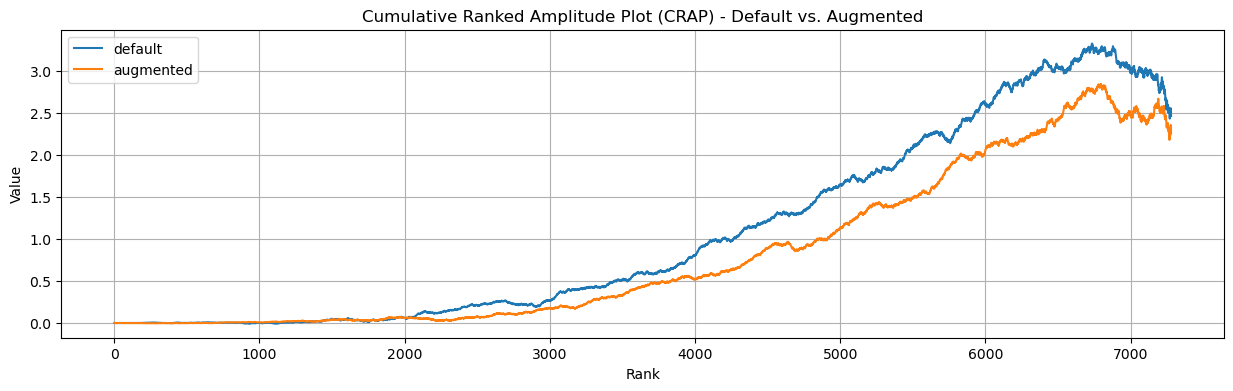

In [34]:
fig, ax = plt.subplots(figsize = (15,4))
ax.plot(crap_default["Cum Return default"], label = "default")
ax.plot(crap_augmented["Cum Return augmented"], label = "augmented")
ax.set_title("Cumulative Ranked Amplitude Plot (CRAP) - Default vs. Augmented")
ax.set_xlabel("Rank")
ax.set_ylabel("Value")
ax.grid()
ax.legend()

#### Q3 - how is this augmented portfolio expected to perform in stressed market scenarios and how does this compare against the default mix ?

Regarding the relevant time horizon(s) you have the following information :
- for investors, the recommended holding period of the Total Return fund is 3-5 years;
- official fund performance reporting is monthly (or 4-weekly);
- the PM can implement (active) portfolio trades once a week;
- a regulatory daily 99% VaR must be reported on a daily basis.


In [35]:
def get_ccrap(portfolio, portfolio_title, stressed_asset, sum_other_assets=True):
    return_all = portfolio.pct_change().iloc[1:].dropna(axis=1)
    return_stressed_asset = return_all[stressed_asset]
    abs_return_stressed_asset = abs(return_stressed_asset)
    rank_return_stressed_asset = abs_return_stressed_asset.rank()
    
    ccrap_stressed_asset = pd.concat([return_all, abs_return_stressed_asset, rank_return_stressed_asset], axis = 1)
    ccrap_stressed_asset.columns = list("Return " + return_all.columns) + ["Abs Return Stressed Asset", "Rank Return Stressed Asset"]
    
    ccrap_stressed_asset.set_index("Rank Return Stressed Asset", inplace = True)
    ccrap_stressed_asset.sort_index(inplace = True)
    ccrap_stressed_asset[list("Cum Return " + return_all.columns)] = ccrap_stressed_asset[list("Return " + return_all.columns)].cumsum()
    
    fig, ax = plt.subplots(figsize = (15,4))
    
    if sum_other_assets:
        
        other_assets = list("Cum Return " + return_all.columns)
        other_assets.remove("Cum Return " + stressed_asset)
        
        ccrap_stressed_asset["Cum Return Other Assets"] = sum([ccrap_stressed_asset[asset] for asset in other_assets])
        ax.plot(ccrap_stressed_asset[["Cum Return " + stressed_asset, "Cum Return Other Assets"]], label = [stressed_asset, "Other Assets"])
        ax.set_title("Conditional Cumulative Ranked Amplitude Plot (CCRAP) - " + portfolio_title + " - Stressed Asset: " + stressed_asset)
        
        numerator = abs(ccrap_stressed_asset["Cum Return " + stressed_asset].iloc[-1] - ccrap_stressed_asset["Cum Return Other Assets"].iloc[-1])
        denominator = abs(max(ccrap_stressed_asset["Cum Return " + stressed_asset]) - max(ccrap_stressed_asset["Cum Return Other Assets"]))
        metric = numerator / denominator

        print(metric)
        
    else:
        ax.plot(ccrap_stressed_asset[list("Cum Return " + return_all.columns)], label = list(return_all.columns))
        ax.set_title("Conditional Cumulative Ranked Amplitude Plot (CCRAP) - " + portfolio_title + " - Stressed Asset: " + stressed_asset)
    
    ax.axvline(ccrap_stressed_asset.index[ccrap_stressed_asset["Cum Return " + stressed_asset] == max(ccrap_stressed_asset["Cum Return " + stressed_asset])], alpha = .5, c = "black", ls = "--")
    ax.set_xlabel("Rank")
    ax.set_ylabel("Value")
    ax.grid()
    ax.legend()
    
    return

0.26035839518891823


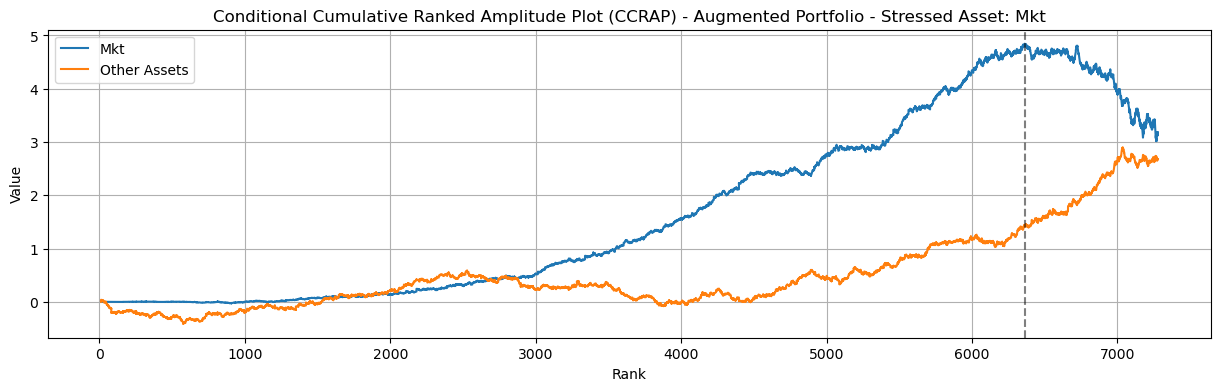

In [36]:
get_ccrap(breakdown_augmented_weights_portfolio, "Augmented Portfolio", "Mkt", True)

0.9950390803895506


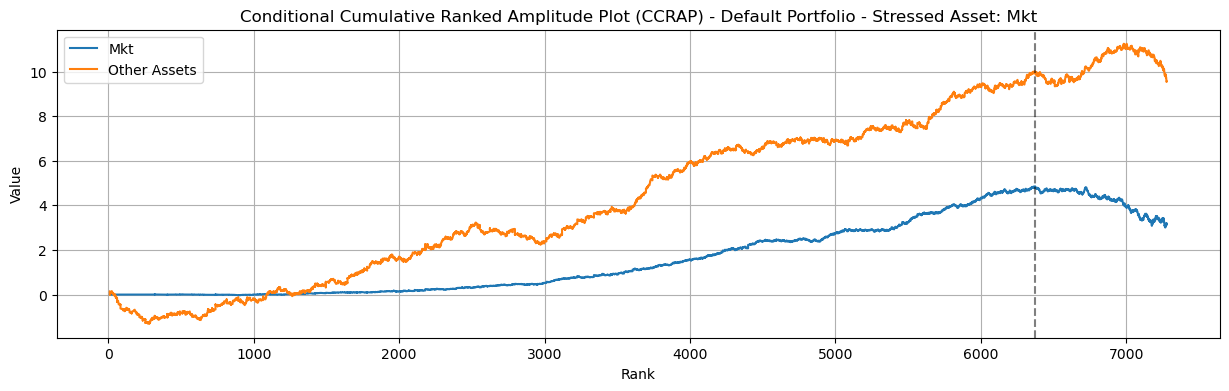

In [37]:
get_ccrap(breakdown_default_portfolio, "Default Portfolio", "Mkt", True)